# Laboratorio: Gestione Variabili Categoriche e Alberi Decisionali

**Programmazione di Applicazioni Data Intensive**  
Laurea in Ingegneria e Scienze Informatiche  
DISI - Università di Bologna, Cesena

Proff. Gianluca Moro, Roberto Pasolini  
`nome.cognome@unibo.it`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Caso di studio: Classificazione rischio di credito

- Nella concessione di un prestito da parte di una banca, è importante valutare la "credibilità" del cliente e prevedere il rischio di insolvenza, ovvero che il prestito non venga interamente restituito
- Si vuole addestrare un modello di classificazione a distinguere "buoni" e "cattivi" debitori, sulla base delle informazioni demografiche e finanziarie a disposizione su di loro
- Prendiamo come esempio una [versione semplificata](https://www.kaggle.com/uciml/german-credit) del dataset [Statlog (German Credit Data)](https://archive.ics.uci.edu/ml/datasets/Statlog+%28German+Credit+Data%29)
  - sono considerate solo le colonne con le informazioni più rilevanti
  - al posto dei codici "A11", ecc. vengono usate etichette comprensibili

In [2]:
import os.path
if not os.path.exists("german_credit.csv"):
    from urllib.request import urlretrieve
    urlretrieve("https://storage.googleapis.com/kaggle-forum-message-attachments/237294/7771/german_credit_data.csv", "german_credit.csv")

- Carichiamo il dataset (la prima colonna è un numero sequenziale, la usiamo come indice)

In [3]:
data = pd.read_csv("german_credit.csv", index_col=0)
data

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad
...,...,...,...,...,...,...,...,...,...,...
995,31,female,1,own,little,NaN,1736,12,furniture/equipment,good
996,40,male,3,own,little,little,3857,30,car,good
997,38,male,2,own,little,NaN,804,12,radio/TV,good
998,23,male,2,free,little,little,1845,45,radio/TV,bad


- Le colonne descrivono diverse caratteristiche del prestito e del suo richiedente
  - `Age`: età del richiedente
  - `Sex`: sesso del richiedente
  - `Job`: livello generale di skill lavorative, da 0 a 3
  - `Housing`: se il richiedente possiede una casa di proprietà o in affitto
  - `Saving accounts`: quantità indicativa di capitale accumulato in depositi di risparmio (può essere non disponibile)
  - `Checking account`: quantità indicativa di capitale nel conto corrente (può essere non disponibile)
  - `Credit amount`: somma richiesta in prestito
  - `Duration`: durata del prestito in mesi
  - `Purpose`: motivazione indicata per aver richiesto il prestito
  - `Risk`: classificazione del rischio
    - `good`: rischio di insolvenza nullo o basso, il prestito può essere concesso
    - `bad`: rischio di insolvenza consistente, il prestito non può essere concesso

- Vediamo informazioni generali sul dataset, in particolare i tipi delle colonne

In [4]:
data.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 10 columns):
Age                 1000 non-null int64
Sex                 1000 non-null object
Job                 1000 non-null int64
Housing             1000 non-null object
Saving accounts     817 non-null object
Checking account    606 non-null object
Credit amount       1000 non-null int64
Duration            1000 non-null int64
Purpose             1000 non-null object
Risk                1000 non-null object
dtypes: int64(4), object(6)
memory usage: 387.7 KB


- La colonna `Risk` costituisce la classe che il modello deve prevedere, che può essere `good` o `bad`

In [5]:
data["Risk"].value_counts()

good    700
bad     300
Name: Risk, dtype: int64

- Le altre colonne contengono variabili utilizzabili per la predizione, tra le quali possiamo distinguere
  - variabili _numeriche_ (es. `Age`) simili a quelle viste nelle esercitazioni precedenti
  - variabili _categoriche_ (es. `Sex`), ciascuna delle quali può assumere un insieme finito di valori
- Definiamo una lista di variabili numeriche e una di variabili categoriche, che utilizzeremo in seguito

In [6]:
numeric_vars = ["Age", "Job", "Credit amount", "Duration"]
categorical_vars = ["Sex", "Housing", "Saving accounts", "Checking account", "Purpose"]

- Per ottimizzare l'uso di memoria, ricarichiamo il dataset impostando come di tipo `category`
  - le variabili predittive categoriche
  - la variabile da predire `Risk`

In [7]:
data = pd.read_csv(
    "german_credit.csv",
    index_col=0,
    dtype={c: "category" for c in categorical_vars + ["Risk"]}
)

In [8]:
data.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 10 columns):
Age                 1000 non-null int64
Sex                 1000 non-null category
Job                 1000 non-null int64
Housing             1000 non-null category
Saving accounts     817 non-null category
Checking account    606 non-null category
Credit amount       1000 non-null int64
Duration            1000 non-null int64
Purpose             1000 non-null category
Risk                1000 non-null category
dtypes: category(6), int64(4)
memory usage: 47.0 KB


- Come al solito, separiamo le variabili predittive (X) dalla variabile da prevedere (y)...

In [9]:
X = data.drop(columns=["Risk"])
y = data["Risk"]

- ...e suddividiamo i dati in training e validation set

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=1/3, random_state=42)

- I metodi di regressione e classificazione visti finora funzionano con variabili predittive numeriche
  - di queste viene ad es. calcolata una combinazione lineare secondo i coefficienti appresi dal modello
- Questi modelli **non funzionano** in presenza di variabili categoriche
  - se si prova ad es. ad addestrare un modello di regressione logistica su questi dati, abbiamo un errore

In [11]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
# model.fit(X_train, y_train)   # <- errore!

## Esercizio 1: Classificazione sulle sole variabili numeriche

- **(1a)** Definire `X_train_num` e `X_val_num` come proiezioni dei frame `X_train` e `X_val` contenenti le soli variabili numeriche del dataset
- **(1b)** Addestrare un modello di regressione logistica su `X_train_num` e verificarne l'accuratezza su `X_val_num`
- **(1c)** Addestrare e verificare lo stesso modello sugli stessi dati, ma utilizzando una pipeline per standardizzare i dati

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [15]:
X_train_num = X_train[numeric_vars]
X_val_num = X_val[numeric_vars]

In [16]:
model = LogisticRegression(solver="saga")
model.fit(X_train_num, y_train)
model.score(X_val_num, y_val)

/home/rrobby/.venvs/dia2020/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.6946107784431138

In [17]:
model = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(solver="saga"))
])
model.fit(X_train_num, y_train)
model.score(X_val_num, y_val)

0.7155688622754491

## Trattamento delle variabili categoriche: one-hot encoding

- Come si possono utilizzare le variabili categoriche in modelli di classificazione o regressione?
- La soluzione tipica consiste nel convertire le variabili categoriche in numeriche
- Data una variabile categorica X con N valori possibili $a, b, c, \ldots$, il _one-hot encoding_ consiste nel convertirla in N variabili numeriche binarie $X_a, X_b, X_c, \ldots$
- Ciascuna variabile $X_v$
  - vale 1 nei casi in cui $X = v$
  - vale 0 negli altri casi
- Ogni valore di X è in pratica convertito ad un vettore in $\mathbf{R}^N$ con un elemento a 1 e gli altri a 0
  - $a \rightarrow [1,0,0,\ldots]$
  - $b \rightarrow [0,1,0,\ldots]$
  - $c \rightarrow [0,0,1,\ldots]$
  - ...

- scikit-learn fornisce un filtro `OneHotEncoder` per effettuare questa operazione su tutte le variabili di un dataset
- Analizziamone il funzionamento su un sottoinsieme delle variabili categoriche del dataset

In [18]:
X_sample = X[["Sex", "Housing"]]
X_sample.head(5)

,Sex,Housing
0,male,own
1,female,own
2,male,own
3,male,free
4,male,free


- I valori possibili di queste variabili sono 2 per `Sex` e 3 per `Housing`

In [19]:
X["Sex"].cat.categories

Index(['female', 'male'], dtype='object')

In [20]:
X["Housing"].cat.categories

Index(['free', 'own', 'rent'], dtype='object')

- Creiamo un'istanza del filtro specificandone i parametri
  - normalmente il filtro fornisce in uscita matrici sparse, come `CountVectorizer` e `TfidfVectorizer`
  - `sparse=False` indica di generare dei normali array NumPy, lo usiamo per fini dimostrativi

In [21]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=False)

- Come per gli altri filtri, passiamo il primo set di dati a `fit_transform` in modo che il formato dei dati venga appreso

In [22]:
encoder.fit_transform(X_sample)

array([[0., 1., 0., 1., 0.],
       [1., 0., 0., 1., 0.],
       [0., 1., 0., 1., 0.],
       ...,
       [0., 1., 0., 1., 0.],
       [0., 1., 1., 0., 0.],
       [0., 1., 0., 1., 0.]])

- Il filtro ha generato 5 variabili: una per ogni valore possibile per ogni variabile
- In ogni riga è presente un 1 nelle prime 2 colonne (`Sex`) e un altro 1 nelle ultime 3 (`Housing`)
- Col metodo `get_feature_names` è possibile vedere a quale valore corrisponde ciascuna colonna

In [23]:
encoder.get_feature_names()

array(['x0_female', 'x0_male', 'x1_free', 'x1_own', 'x1_rent'],
      dtype=object)

- Passiamo i nomi delle colonne al metodo per utilizzarli al posto di `x0` e `x1`

In [24]:
encoder.get_feature_names(X_sample.columns)

array(['Sex_female', 'Sex_male', 'Housing_free', 'Housing_own',
       'Housing_rent'], dtype=object)

- Usiamo i nomi per visualizzare la matrice ottenuta sopra in un frame

In [25]:
pd.DataFrame(
    encoder.transform(X_sample),
    columns=encoder.get_feature_names(X_sample.columns)
).head(5)

,Sex_female,Sex_male,Housing_free,Housing_own,Housing_rent
0,0.0,1.0,0.0,1.0,0.0
1,1.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,1.0,0.0
3,0.0,1.0,1.0,0.0,0.0
4,0.0,1.0,1.0,0.0,0.0


- Specificando `drop="first"` nei parametri, `OneHotEncoder` genera una variabile binaria in meno per ogni variabile categorica, rappresentando uno dei valori possibili come un vettore di soli zero

In [26]:
encoder = OneHotEncoder(drop="first", sparse=False)
pd.DataFrame(
    encoder.fit_transform(X_sample),
    columns=encoder.get_feature_names(X_sample.columns)
).head(5)

,Sex_male,Housing_own,Housing_rent
0,1.0,1.0,0.0
1,0.0,1.0,0.0
2,1.0,1.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0


- In questo esempio sono state scartate le variabili `Sex_female` e `Housing_free`
  - i casi `Sex_female` si riconoscono implicitamente da `Sex_male = 0` (es. riga 1)
  - i casi `Housing_free` si riconoscono da `Housing_own = Housing_rent = 0` (es. ultime due righe)
- Il vantaggio di questo accorgimento è che si evita di introdurre variabili collineari che possono causare problemi in alcuni modelli (es. modelli lineari senza regolarizzazione)
- Lo svantaggio è che si introduce un'asimmetria nella rappresentazione dei dati che può causare bias in altri modelli (es. modelli lineari con regolarizzazione)

- Usiamo ora il filtro `OneHotEncoder` per addestrare e validare un classificatore basato su tutte le variabili categoriche
- Creiamo delle proiezioni delle matrici `X_train` e `X_val` contenenti le sole variabili categoriche

In [27]:
X_train_cat = X_train[categorical_vars]
X_val_cat = X_val[categorical_vars]

- Creiamo un nuovo encoder
  - questa volta lasciamo le impostazioni di default, per cui vengono restituite matrici sparse (convertibili a normali array col metodo `toarray()`)

In [28]:
encoder = OneHotEncoder()

- Addestriamo un semplice modello di regressione logistica sul training set, addestrando ed applicando (`fit_transform`) l'encoder su di esso

In [29]:
model = LogisticRegression(solver="saga")
model.fit(encoder.fit_transform(X_train_cat), y_train)

/home/rrobby/.venvs/dia2020/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(solver='saga')

- Calcoliamo quindi l'accuratezza del modello sul validation set, che viene preprocessato usando lo stesso encoder

In [30]:
model.score(encoder.transform(X_val_cat), y_val)

0.7335329341317365

- Verificando l'ordine delle classi, vediamo che la classe "bad" è considerata come negativa e quella "good" come positiva

In [31]:
model.classes_

array(['bad', 'good'], dtype=object)

- Estraiamo i coefficienti del modello associandoli ai nomi delle rispettive variabili generate dall'encoder

In [32]:
pd.Series(
    model.coef_[0],
    index=encoder.get_feature_names(X_train_cat.columns)
)

Sex_female                     0.009224
Sex_male                       0.401956
Housing_free                  -0.200418
Housing_own                    0.487400
Housing_rent                   0.124197
Saving accounts_little        -0.314827
Saving accounts_moderate      -0.264351
Saving accounts_quite rich     0.228984
Saving accounts_rich           0.572825
Saving accounts_nan            0.188548
Checking account_little       -0.650421
Checking account_moderate     -0.378314
Checking account_rich          0.482221
Checking account_nan           0.957693
Purpose_business              -0.256976
Purpose_car                    0.056994
Purpose_domestic appliances   -0.080781
Purpose_education             -0.345462
Purpose_furniture/equipment    0.354464
Purpose_radio/TV               0.499402
Purpose_repairs                0.171943
Purpose_vacation/others        0.011595
dtype: float64

- Da quì vediamo quali caratteristiche evidenziate dalle variabili categoriche tendono ad abbassare (negativo, `bad`) o alzare (positivo, `good`) la reputazione creditizia dei clienti
  - ad esempio, l'avere una casa di proprietà (`Housing_own`) è visto come un'indicatore positivo

## Esercizio 2: One-hot encoding in una pipeline

- Utilizzando l'interfaccia standard dei filtri di scikit-learn, il one-hot encoder può essere utilizzato in una pipeline
- Definire un modello di regressione logistica come quello addestrato sopra in una pipeline che applichi l'encoding delle variabili categoriche, addestrarlo su `X_train_cat` e validarlo su `X_val_cat`

In [33]:
from sklearn.pipeline import Pipeline

In [35]:
model = Pipeline([
    ("encoder", OneHotEncoder()),
    ("logreg",  LogisticRegression(solver="saga"))
])
model.fit(X_train_cat, y_train)
model.score(X_val_cat, y_val)

/home/rrobby/.venvs/dia2020/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.7335329341317365

## Preprocessing differenziato delle colonne

- Abbiamo visto come addestrare modelli basati su variabili numeriche oppure su variabili categoriche
- È possibile utilizzare tutte le variabili (numeriche e categoriche) in un unico modello?
- Il one-hot encoder converte le variabili categoriche in numeriche, queste possono essere combinate a quelle che sono già numeriche
- Vediamo come eseguire questa procedura manualmente, applicando anche la standardizzazione alle variabili numeriche
- Per prima cosa, creiamo uno `StandardScaler` per le variabili già numeriche e un `OneHotEncoder` per quelle categoriche

In [36]:
scaler = StandardScaler()
encoder = OneHotEncoder(sparse=False)

- Quindi applichiamo i filtri alle rispettive colonne del training set e concateno per colonne le matrici ottenute
  - `np.c_[A, B, C, ...]` costruisce un array concatenendo per colonne (orizzontalmente) gli array A, B, C, ...
  - si può eseguire la stessa operazione per righe (verticalmente) con `np.r_`

In [37]:
X_train_combo = np.c_[
    scaler.fit_transform(X_train_num),
    encoder.fit_transform(X_train_cat)
]

- Eseguiamo la stessa operazione sul validation set usando i filtri già addestrati

In [38]:
X_val_combo = np.c_[
    scaler.transform(X_val_num),
    encoder.transform(X_val_cat)
]

- Infine addestriamo e validiamo un modello utilizzando le matrici combinate

In [39]:
model = LogisticRegression(solver="saga")
model.fit(X_train_combo, y_train)
model.score(X_val_combo, y_val)

/home/rrobby/.venvs/dia2020/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.7335329341317365

- In questo modo abbiamo costruito un modello combinando insieme matrici numeriche e categoriche
- Abbiamo però svolto operazioni diverse dalle solite che definiamo in una pipeline
  - suddivisione del dataset in gruppi di colonne
  - applicazione di filtri diversi a ciascun gruppo
  - concatenazione delle colonne risultanti da ciascun gruppo

- Per questi casi, scikit-learn fornisce un filtro composito `ColumnTransformer`
- Un oggetto `ColumnTransformer` è definito da una lista di gruppi, ciascuno dei quali è definito da una tupla contenente:
  - un nome da dare al gruppo, usato per riferirsi ad esso, simile ai nomi in una `Pipeline`
  - un filtro da applicare al gruppo
    - può essere una `Pipeline` con una sequenza di filtri
  - una lista di nomi di colonne che fanno parte del gruppo
    - se le colonne non hanno nome (es. array NumPy), usare gli indici
- Definiamo ad esempio un `ColumnTransformer` che applichi `StandardScaler` e `OneHotEncoder` sui due gruppi di colonne come sopra

In [40]:
from sklearn.compose import ColumnTransformer
preprocessor = ColumnTransformer([
    # nome           filtro            colonne
    ( "numeric"    , StandardScaler(), numeric_vars     ),
    ( "categorical", OneHotEncoder() , categorical_vars )
])

- Il trasformatore ha la stessa interfaccia di un filtro, possiamo quindi usarlo come sempre per trasformare il training set e il validation set
  - passiamo i due set per intero: il trasformatore li suddividerà in gruppi da trattare separatamente secondo la definizione sopra

In [41]:
X_train_proc = preprocessor.fit_transform(X_train)
X_val_proc = preprocessor.transform(X_val)

- Il risultato è esattamente uguale a quello ottenuto sopra concatenando gli array risultanti dalle applicazioni dei filtri sui dati separati manualmente

In [42]:
np.array_equal(X_train_combo, X_train_proc)

True

In [43]:
np.array_equal(X_val_combo, X_val_proc)

True

In [44]:
model = LogisticRegression(solver="saga")
model.fit(X_train_proc, y_train)
model.score(X_val_proc, y_val)

/home/rrobby/.venvs/dia2020/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.7335329341317365

- Anche il `ColumnTransformer`, essendo un filtro, può essere usato all'interno di una pipeline
- Otteniamo così anche in questo caso un unico oggetto composito che contiene il modello di classificazione insieme a tutti i filtri da applicare ai dati

In [45]:
# definizione con transformer definito a parte
preprocessor = ColumnTransformer([
    ("numeric"    , StandardScaler(), numeric_vars    ),
    ("categorical", OneHotEncoder() , categorical_vars)
])
model = Pipeline([
    ("preproc", preprocessor),
    ("logreg" , LogisticRegression(solver="saga"))
])

# definizione equivalente con transformer innestato
model = Pipeline([
    ("preproc", ColumnTransformer([
        ("numeric", StandardScaler(), numeric_vars),
        ("categorical", OneHotEncoder(), categorical_vars)
    ])),
    ("logreg" , LogisticRegression(solver="saga"))
])

model.fit(X_train, y_train)
model.score(X_val, y_val)

/home/rrobby/.venvs/dia2020/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.7335329341317365

- Analogamente a `Pipeline.named_steps`, `ColumnTranformers` permette di accedere ai singoli filtri tramite il dizionario `named_transformers_`
- Ad esempio, per ispezionare le medie rilevate sul training set dallo `StandardScaler` sulle variabili numeriche:

In [46]:
pd.Series(
    model.named_steps["preproc"].named_transformers_["numeric"].mean_,
    index=numeric_vars
)

Age                35.388889
Job                 1.930931
Credit amount    3430.115616
Duration           21.256757
dtype: float64

- Nella definizione del `ColumnTransformer` si può usare la stringa `"passthrough"` al posto di un filtro per utilizzare i dati senza applicare filtri
- Come ulteriore opzione, si può utilizzare la stringa `"drop"` per scartare completamente i dati
- Ad esempio, modifichiamo la pipeline sopra per non applicare la standardizzazione alle variabili numeriche

In [47]:
model = Pipeline([
    ("preproc", ColumnTransformer([
        ("numeric", "passthrough", numeric_vars),          # <---
        ("categorical", OneHotEncoder(), categorical_vars)
    ])),
    ("logreg" , LogisticRegression(solver="saga"))
])
model.fit(X_train, y_train)
model.score(X_val, y_val)

/home/rrobby/.venvs/dia2020/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.6946107784431138

- Si può anche usare l'opzione `remainder` per indicare un filtro o un comportamento di default da applicare alle colonne che non fanno parte di alcun gruppo
- Riscriviamo l'esempio sopra definendo esplicitamente solo il gruppo di variabili categoriche e definendo il comportamento per tutte le altre
  - di default `remainder="drop"`, ovvero tutte le variabili non processate sono scartate

In [48]:
model = Pipeline([
    ("preproc", ColumnTransformer([
        ("categorical", OneHotEncoder(), categorical_vars)
    ], remainder="passthrough")),                          # <---
    ("logreg",  LogisticRegression(solver="saga"))
])
model.fit(X_train, y_train)
model.score(X_val, y_val)

/home/rrobby/.venvs/dia2020/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.6946107784431138

- In una grid search, possiamo riferirci ai singoli filtri del transformer e ai loro parametri con modalità analoghe a quelle viste nelle pipeline più semplici
  - si ipotizzi di avere un transformer come componente di una pipeline con nome `preproc`, come negli esempi sopra
  - per riferirsi al filtro di un gruppo `group`, si indica `preproc__group`
  - per riferirsi al parametro `par` di tale filtro, si indica `preproc__group__par`
- Definiamo ad esempio una grid search con modello simile a quello sopra in cui
  - alle variabili numeriche può essere applicato o meno `StandardScaler`
  - il one-hot encoding delle variabili categoriche può essere applicato con `drop="first"` o `drop=None` (default)

In [49]:
model = Pipeline([
    ("preproc", ColumnTransformer([
        ("numeric", ..., numeric_vars),  # possiamo usare un valore arbitrario al posto di "..."
        ("categorical", OneHotEncoder(), categorical_vars)
    ])),
    ("logreg" , LogisticRegression(solver="saga"))
])
grid = {
    # variazione dell'intero filtro da usare
    "preproc__numeric": ["passthrough", StandardScaler()],
    # variazione di un singolo parametro di un filtro
    "preproc__categorical__drop": [None, "first"]
}

- Eseguiamo la grid search, usando ad esempio la stratified cross validation a 3 fold

In [50]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
skf = StratifiedKFold(3, shuffle=True, random_state=42)
gs = GridSearchCV(model, grid, cv=skf)
gs.fit(X_train, y_train);

/home/rrobby/.venvs/dia2020/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/rrobby/.venvs/dia2020/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/rrobby/.venvs/dia2020/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/rrobby/.venvs/dia2020/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/rrobby/.venvs/dia2020/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: Conver

- Vediamo la configurazione migliore individuata e il confronto tra tutte quelle testate

In [51]:
gs.best_params_

{'preproc__categorical__drop': None, 'preproc__numeric': StandardScaler()}

In [52]:
pd.DataFrame(gs.cv_results_).sort_values("rank_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preproc__categorical__drop,param_preproc__numeric,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
1,0.024430,0.001304,0.005757,0.000129,None,StandardScaler(),"{'preproc__categorical__drop': None, 'preproc_...",0.743243,0.720721,0.770270,0.744745,0.020256,1
3,0.018927,0.001620,0.006183,0.001108,first,StandardScaler(),"{'preproc__categorical__drop': 'first', 'prepr...",0.743243,0.725225,0.756757,0.741742,0.012916,2
0,0.022214,0.001293,0.004885,0.000487,None,passthrough,"{'preproc__categorical__drop': None, 'preproc_...",0.702703,0.702703,0.702703,0.702703,0.000000,3
2,0.021673,0.001617,0.004427,0.000419,first,passthrough,"{'preproc__categorical__drop': 'first', 'prepr...",0.702703,0.702703,0.702703,0.702703,0.000000,3


## Esercizio 3: Grid search su pipeline complessa

- Effettuare la grid search sul training set con cross validation come sopra (`skf`) ed estrarre la configurazione migliore e l'accuratezza sul validation set su
  - **(3a)** un modello di regressione logistica su tutte le variabili con
    - one-hot encoding delle variabili categoriche con tutte le impostazioni di default
    - generazione di feature polinomiali dalle variabili numeriche con grado da 1 a 3
    - parametro C della regressione logistica pari a 0.01, 1 o 100
  - **(3b)** un modello simile, ma con standardizzazione delle variabili numeriche prima di generare le feature polinomiali
    - utilizzare una pipeline per concatenare i due filtri

In [53]:
from sklearn.preprocessing import PolynomialFeatures

In [55]:
model = Pipeline([
    ("preproc", ColumnTransformer([
        ("numeric", PolynomialFeatures(include_bias=False), numeric_vars),
        ("categorical", OneHotEncoder(), categorical_vars)
    ])),
    ("logreg" , LogisticRegression(solver="saga"))
])
grid = {
    "preproc__numeric__degree": [1, 2, 3],
    "logreg__C": [0.01, 1, 100]
}
gs = GridSearchCV(model, grid, cv=skf)
gs.fit(X_train, y_train)
gs.best_params_

/home/rrobby/.venvs/dia2020/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/rrobby/.venvs/dia2020/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/rrobby/.venvs/dia2020/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/rrobby/.venvs/dia2020/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/rrobby/.venvs/dia2020/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: Conver

{'logreg__C': 0.01, 'preproc__numeric__degree': 1}

In [56]:
gs.score(X_val, y_val)

0.6946107784431138

In [57]:
model = Pipeline([
    ("preproc", ColumnTransformer([
        ("numeric", Pipeline([
            ("scale", StandardScaler()),
            ("poly", PolynomialFeatures(include_bias=False))
        ]), numeric_vars),
        ("categorical", OneHotEncoder(), categorical_vars)
    ])),
    ("logreg" , LogisticRegression(solver="saga"))
])
grid = {
    "preproc__numeric__poly__degree": [1, 2, 3],
    "logreg__C": [0.01, 1, 100]
}
gs = GridSearchCV(model, grid, cv=skf)
gs.fit(X_train, y_train)
gs.best_params_

/home/rrobby/.venvs/dia2020/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/rrobby/.venvs/dia2020/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/rrobby/.venvs/dia2020/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/rrobby/.venvs/dia2020/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/rrobby/.venvs/dia2020/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: Conver

{'logreg__C': 1, 'preproc__numeric__poly__degree': 1}

In [58]:
gs.score(X_val, y_val)

0.7335329341317365

## Classificazione con alberi decisionali

- I modelli di classificazione visti finora si basano su iperpiani descritti da equazioni (lineari o non) su tutte le variabili
- Gli alberi decisionali costituiscono un approccio differente: la classificazione avviene in base ad una serie di decisioni "semplici", basate ciascuna su una sola variabile
  - ciascuna decisione porta ad un ramo diverso dell'albero
  - geometricamente è come se, invece di un unico iperpiano con coefficienti angolari arbitrari, avessimo molteplici iperpiani descritti ciascuno da un'equazione di una sola delle variabili predittive
- I modelli ad alberi decisionali hanno alcuni vantaggi:
  - un albero decisionale (se di piccole dimensioni) è spesso più facilmente interpretabile da una persona rispetto ad un insieme di coefficienti numerici
  - è concettualmente possibile trattare variabili categoriche (ma in scikit-learn ne è necessario comunque il one-hot encoding)

- Un modello ad albero decisionale è rappresentato da un oggetto `DecisionTreeClassifier`
- Gli iperparametri del modello consentono di regolarne la complessità dell'albero risultante
- Ad esempio tramite il parametro `max_depth` possiamo controllare la profondità massima dell'albero
  - per ora la limitiamo a 2 per facilitare la lettura dell'albero stesso

In [59]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(max_depth=2, random_state=42)

- Addestriamo il modello sulle variabili numeriche del dataset

In [60]:
model.fit(X_train_num, y_train)

DecisionTreeClassifier(max_depth=2, random_state=42)

- È stato così costruito un albero decisionale in base ai dati del training set
- L'albero può essere ispezionato per verificare quali variabili sono ritenute significative
- Per ottenere una rappresentazione testuale dell'albero, viene fornita la funzione `export_text`
  - specificare i nomi delle variabili come `feature_names` per usarle come etichette nell'albero

In [61]:
from sklearn.tree import export_text
print(export_text(model, feature_names=numeric_vars))

|--- Duration <= 33.00
|   |--- Credit amount <= 8195.00
|   |   |--- class: good
|   |--- Credit amount >  8195.00
|   |   |--- class: bad
|--- Duration >  33.00
|   |--- Age <= 26.50
|   |   |--- class: bad
|   |--- Age >  26.50
|   |   |--- class: good



La rappresentazione mostra intuitivamente come il modello classifichi ciascuna richiesta di prestito analizzata

- Per prima cosa, considera la **durata del prestito** (`Duration`) in mesi
  - se la durata non supera i **33 mesi**, considera la **somma richiesta** in prestito (`Credit amount`)
    - se non superiore a **8.195**, classifica la richiesta positivamente (`good`)
    - altrimenti, se superiore a 8.195, classifica la richiesta negativamente (`bad`)
  - altrimenti, se la durata è superiore a 33 mesi, considera l'**età** del richiedente (`Age`)
    - se l'età non supera i **26** anni, classifica la richiesta negativamente (`bad`)
    - altrimenti, se supera i 26 anni, classifica la richiesta positivamente (`good`)

- Sia dato il seguente caso come esempio

In [62]:
#         Age  Job  Credit amt.  Duration
sample = [ 35,   2,      10000,        24 ]

- Questo sarà classificato come `bad`, in quanto
  - durata = 24 < 33
  - somma richiesta = 10.000 > 8.195
- Possiamo verificarlo con `predict`
  - ricordare che a `predict` va sempre passata una lista o array di casi, anche se uno solo

In [63]:
model.predict([sample])

array(['bad'], dtype=object)

- Per visualizzare invece graficamente l'albero di un modello, viene fornita la funzione `plot_tree`

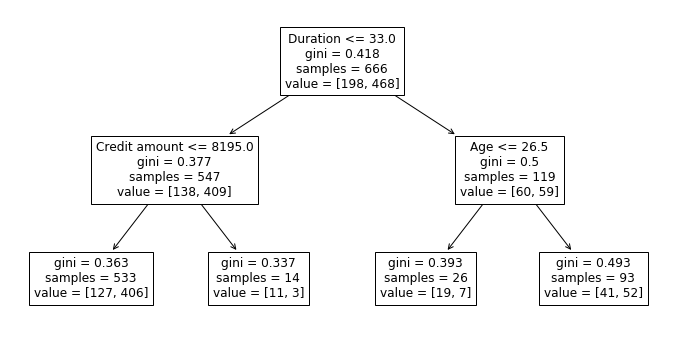

In [64]:
from sklearn.tree import plot_tree
plt.figure(figsize=(12, 6))
plot_tree(model, feature_names=numeric_vars);

- Ogni blocco rappresenta un nodo dell'albero
  - in cima alla figura viene mostrata la _radice_, il primo nodo valutato per classificare un'istanza
  - nella riga sotto si possono vedere i due nodi intermedi dell'albero
  - in fondo si possono vedere le quattro _foglie_, in cui viene decisa la classe dell'istanza
- Il numero totale di foglie di un albero può essere ottenuto dal metodo `get_n_leaves`

In [65]:
model.get_n_leaves()

4

- Ad ogni nodo dell'albero sono mostrati in ordine
  - il criterio in base alla quale i dati sono suddivisi (assente nelle foglie)
    - se soddisfatta, viene seguito il ramo a sinistra del nodo
    - altrimenti, viene seguito il ramo a destra
  - il coefficiente GINI, usato per definire la "qualità" della suddivisione
  - il numero totale di istanze del training set considerate (`samples`)
  - il numero di istanze per ciascuna classe, ordinate come definito dal modello (`value`)

In [66]:
model.classes_

array(['bad', 'good'], dtype=object)

- La radice indica ad esempio che sono stati analizzati in tutto 666 prestiti, suddivisi tra 198 `bad` e 468 `good`
- Il nodo intermedio a sinistra indica che 547 prestiti hanno avuto una durata non oltre 33 mesi, questi sono suddivisi tra 138 `bad` e 409 `good`
- Di questi 547, 533 erano di importo non oltre 8.195, questi erano suddivisi tra 127 `bad` e 406 `good`, per cui i prestiti che ricadono in questa foglia sono classificati `good`

- Per valutare l'accuratezza dell'albero decisionale, usiamo come al solito il metodo `score`
- Vediamo l'accuratezza su training e validation set

In [67]:
model.score(X_train_num, y_train)

0.7327327327327328

In [68]:
model.score(X_val_num, y_val)

0.7125748502994012

- Proviamo ora ad addestrare un nuovo modello aumentando la profondità massima dell'albero da 2 a 5

In [69]:
model = DecisionTreeClassifier(max_depth=5, random_state=42)
model.fit(X_train_num, y_train);

- Stampando la rappresentazione testuale dell'albero, vediamo che è molto più complesso di quello sopra

In [70]:
print(export_text(model, feature_names=numeric_vars))

|--- Duration <= 33.00
|   |--- Credit amount <= 8195.00
|   |   |--- Age <= 34.50
|   |   |   |--- Credit amount <= 1387.00
|   |   |   |   |--- Age <= 32.50
|   |   |   |   |   |--- class: good
|   |   |   |   |--- Age >  32.50
|   |   |   |   |   |--- class: bad
|   |   |   |--- Credit amount >  1387.00
|   |   |   |   |--- Age <= 22.50
|   |   |   |   |   |--- class: good
|   |   |   |   |--- Age >  22.50
|   |   |   |   |   |--- class: good
|   |   |--- Age >  34.50
|   |   |   |--- Duration <= 11.50
|   |   |   |   |--- Job <= 2.50
|   |   |   |   |   |--- class: good
|   |   |   |   |--- Job >  2.50
|   |   |   |   |   |--- class: good
|   |   |   |--- Duration >  11.50
|   |   |   |   |--- Credit amount <= 1383.50
|   |   |   |   |   |--- class: good
|   |   |   |   |--- Credit amount >  1383.50
|   |   |   |   |   |--- class: good
|   |--- Credit amount >  8195.00
|   |   |--- Credit amount <= 10975.50
|   |   |   |--- Credit amount <= 9127.50
|   |   |   |   |--- Age <= 25.00

- Il numero totale di foglie ora è:

In [71]:
model.get_n_leaves()

23

- Per rendere la stampa più compatta, possiamo indicare una `max_depth` in `export_text` per stampare i nodi solamente fino ad una profondità data
  - sono indicati i punti in cui la rappresentazione è stata tagliata, con la loro profondità

In [72]:
print(export_text(model, feature_names=numeric_vars, max_depth=2))

|--- Duration <= 33.00
|   |--- Credit amount <= 8195.00
|   |   |--- Age <= 34.50
|   |   |   |--- truncated branch of depth 3
|   |   |--- Age >  34.50
|   |   |   |--- truncated branch of depth 3
|   |--- Credit amount >  8195.00
|   |   |--- Credit amount <= 10975.50
|   |   |   |--- truncated branch of depth 3
|   |   |--- Credit amount >  10975.50
|   |   |   |--- class: bad
|--- Duration >  33.00
|   |--- Age <= 26.50
|   |   |--- Duration <= 54.00
|   |   |   |--- truncated branch of depth 3
|   |   |--- Duration >  54.00
|   |   |   |--- class: good
|   |--- Age >  26.50
|   |   |--- Credit amount <= 2138.00
|   |   |   |--- truncated branch of depth 2
|   |   |--- Credit amount >  2138.00
|   |   |   |--- truncated branch of depth 3



- Il parametro `max_depth` può essere utilizzato anche in `plot_tree`
  - si consiglia di utilizzarlo sempre, per evitare di generare figure "pesanti"

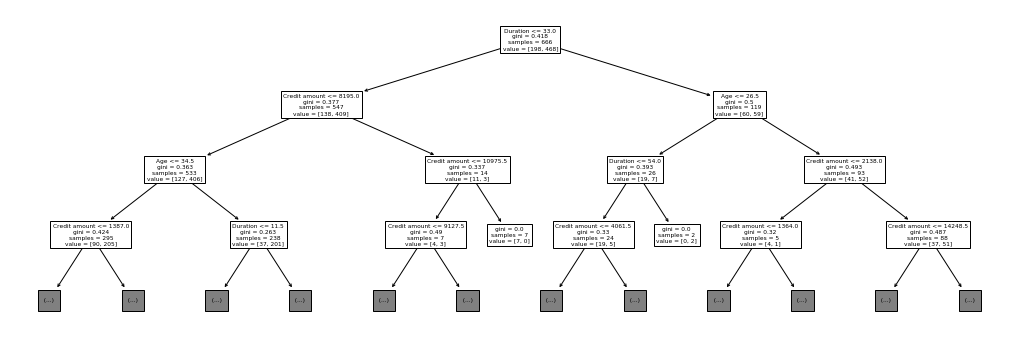

In [73]:
plt.figure(figsize=(18, 6))
plot_tree(model, feature_names=numeric_vars, max_depth=3);

- I riquadri grigi nella figura indicano le porzioni tagliate dell'albero
- Nell'ultima riga sopra di essi si possono comunque vedere due foglie dell'albero (4° e 6° nodo da sinistra)
- Questi sono nodi _puri_, ovvero nodi in cui tutte le istanze di training sono della stessa classe, che quindi non sono ulteriormente suddivisi
- Specificando `filled=True` in `plot_tree`, è possibile colorare i nodi in base alla classe prevalente e alla purezza
  - i nodi hanno colore tendente all'azzurro o all'arancione a seconda della classe prevalente
  - il colore è tanto più intenso quanto più è la purezza, ovvero quanto più una classe prevale sull'altra

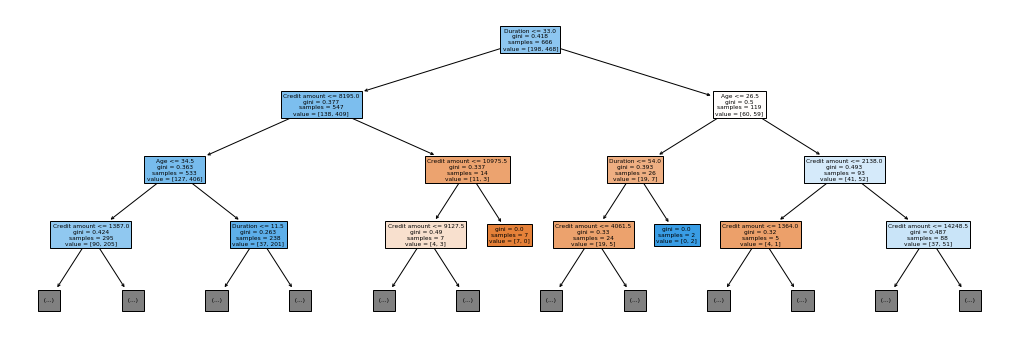

In [74]:
plt.figure(figsize=(18, 6))
plot_tree(model, feature_names=numeric_vars, max_depth=3, filled=True);

- Calcoliamo anche questa volta l'accuratezza su training e validation set

In [75]:
model.score(X_train_num, y_train)

0.7627627627627628

In [76]:
model.score(X_val_num, y_val)

0.7125748502994012

- L'accuratezza sul training set è leggermente aumentata, quella sul validation set invariata

- Cosa succede se non viene limitata la profondità massima dell'albero?
- Addestriamo un modello senza specificare una `max_depth`

In [77]:
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train_num, y_train);

- Oltre al numero di foglie con `get_n_leaves`, possiamo ottenere la profondità massima raggiunta dall'albero con `get_depth`

In [78]:
model.get_depth()

21

In [79]:
model.get_n_leaves()

212

- Calcoliamo l'accuratezza su training e validation set

In [80]:
model.score(X_train_num, y_train)

1.0

In [81]:
model.score(X_val_num, y_val)

0.6646706586826348

- Non avendo limiti di profondità, l'albero può essere costruito in modo da classificare alla perfezione tutte le istanze del training set
- Tuttavia, l'accuratezza sul validation set è diminuita!
- L'impostazione di una profondità massima può essere importante sia per limitare la complessità dell'albero che per evitare l'overfitting, come accade in questo caso

- Oltre alla profondità massima, è possibile impostare altri criteri per limitare la complessità di un albero
- Ad esempio con `min_samples_split` viene impostato il numero minimo di casi di training (`samples`) contenuti in un nodo intermedio: nodi con un numero inferiore di casi non possono essere ulteriormente suddivisi
  - è possibile impostare sia un numero intero assoluto che una frazione rispetto ai casi di training
- Costruiamo ad esempio un albero decisionale impostando che i nodi devono contenere almeno 60 casi di training per essere suddivisi

In [82]:
model = DecisionTreeClassifier(min_samples_split=60, random_state=42)
model.fit(X_train_num, y_train);

- Otteniamo un albero con un numero di foglie simile a quello con `max_depth=5`, ma più profondo

In [83]:
model.get_depth()

9

In [84]:
model.get_n_leaves()

24

- Questo perché col criterio `min_samples_split` otteniamo suddivisioni più profonde nei rami in cui ricadono molte istanze di training
- Questo si può osservare anche dalle rappresentazioni testuale e grafica dell'albero

In [85]:
print(export_text(model, feature_names=numeric_vars, max_depth=2))

|--- Duration <= 33.00
|   |--- Credit amount <= 8195.00
|   |   |--- Age <= 34.50
|   |   |   |--- truncated branch of depth 7
|   |   |--- Age >  34.50
|   |   |   |--- truncated branch of depth 5
|   |--- Credit amount >  8195.00
|   |   |--- class: bad
|--- Duration >  33.00
|   |--- Age <= 26.50
|   |   |--- class: bad
|   |--- Age >  26.50
|   |   |--- Credit amount <= 2138.00
|   |   |   |--- class: bad
|   |   |--- Credit amount >  2138.00
|   |   |   |--- truncated branch of depth 4



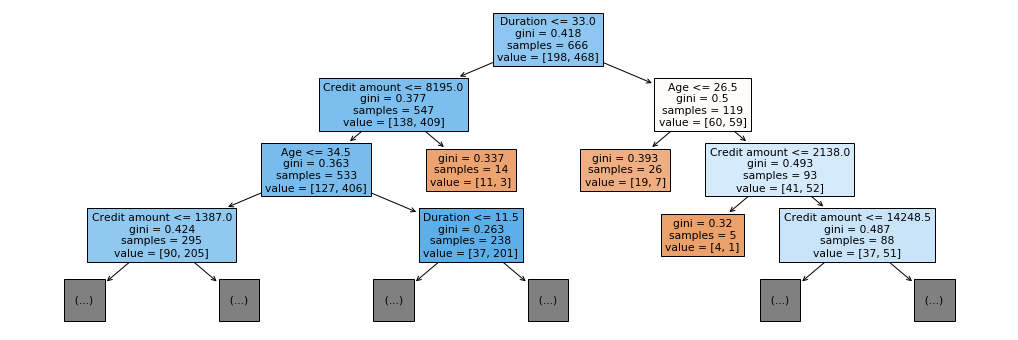

In [86]:
plt.figure(figsize=(18, 6))
plot_tree(model, feature_names=numeric_vars, max_depth=3, filled=True);

- Si noti come la profondità massima dell'albero è 9, ma si trovano delle foglie già al livello 2

In [87]:
model.score(X_train_num, y_train)

0.7657657657657657

In [88]:
model.score(X_val_num, y_val)

0.6916167664670658

## Esercizio 4: Grid search su alberi per classificazione

- Eseguire una grid search sul training set con le stesse modalità di CV usate sopra su un modello ad albero decisionale che
  - utilizzi in ogni caso gli attributi categorici (applicando one-hot encoding con i parametri di default)
  - utilizzi o meno gli attributi numerici, senza applicare filtri
    - al posto dei filtri usare `"drop"` per scartare i dati o `"passthrough"` per utilizzarli senza trasformarli
  - abbia profondità massima 5, 10 o non limitata (`None`)
  - abbia numero minimo di istanze per nodo intermedio pari a 2 (default), 50, 100
- Stampare la configurazione migliore e l'accuratezza sul validation set

In [90]:
model = Pipeline([
    ("preproc", ColumnTransformer([
        ("numeric", ..., numeric_vars),
        ("categorical", OneHotEncoder(), categorical_vars)
    ])),
    ("tree", DecisionTreeClassifier(random_state=42))
])
grid = {
    "preproc__numeric": ["drop", "passthrough"],
    "tree__max_depth": [5, 10, None],
    "tree__min_samples_split": [2, 50, 100]
}
gs = GridSearchCV(model, grid, cv=skf)
gs.fit(X_train, y_train)
gs.best_params_

{'preproc__numeric': 'passthrough',
 'tree__max_depth': 5,
 'tree__min_samples_split': 50}

In [91]:
gs.score(X_val, y_val)

0.7005988023952096

## Regressione con alberi decisionali

- Oltre alla classificazione, gli alberi decisionali possono essere usati anche in modelli di regressione
- Invece di una classe, ad ogni foglia è associato un valore della variabile continua da prevedere
- Questo tipo di modello in pratica prevede valori identici su istanze leggermente diverse, ma permette di modellare relazioni non lineari arbitrarie tra X e y
- Per visualizzare l'output di un modello di regressione ad albero, riprendiamo l'esempio di regressione univariata sulla predizione dei consumi elettrici in base alle temperature

In [92]:
import os.path
if not os.path.exists("power.csv"):
    from urllib.request import urlretrieve
    urlretrieve("https://git.io/vpaM1", "power.csv")

In [93]:
power = pd.read_csv("power.csv", index_col="date", parse_dates=["date"])
power.head(5)

,demand,temp
date,,
2015-01-01,1.736065,1.7
2015-01-02,1.831672,2.2
2015-01-03,1.714934,14.4
2015-01-04,1.628577,15.6
2015-01-05,2.045394,0.0


- Come già visto, d dati relativi a tutto l'anno sono distribuiti in modo non lineare: i consumi si alzano sia nei mesi più caldi (per l'aria condizionata) che in quelli più freddi (per gli impianti di riscaldamento elettrici)

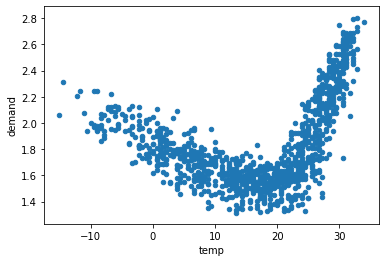

In [94]:
power.plot.scatter("temp", "demand");

- Usiamo i dati degli anni 2015 e 2016 come training set e quelli del 2017 come validation set

In [95]:
is_train = power.index.year < 2017
X_train = power.loc[is_train, ["temp"]]
y_train = power.loc[is_train, "demand"]
X_val = power.loc[~is_train, ["temp"]]
y_val = power.loc[~is_train, "demand"]

- Un modello di regressione ad albero è rappresentato da un oggetto `DecisionTreeRegressor`, su cui si possono impostare gli stessi iperparametri di `DecisionTreeClassifier`
- Addestriamo un primo modello di regressione ad albero decisionale con profondità massima 2

In [96]:
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor(max_depth=2, random_state=42)
model.fit(X_train, y_train);

- Possiamo visualizzare l'albero sia in forma testuale che grafica usando le stesse funzioni viste sopra
  - in ogni nodo avremo un valore previsto della variabile dipendente (la quantità di consumi)

In [97]:
from sklearn.tree import export_text, plot_tree
print(export_text(model, feature_names=["temp"]))

|--- temp <= 26.40
|   |--- temp <= 1.40
|   |   |--- value: [1.97]
|   |--- temp >  1.40
|   |   |--- value: [1.66]
|--- temp >  26.40
|   |--- temp <= 29.15
|   |   |--- value: [2.14]
|   |--- temp >  29.15
|   |   |--- value: [2.48]



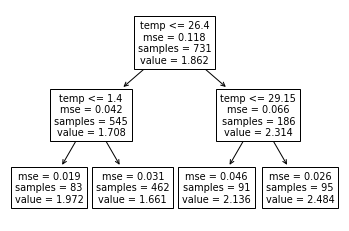

In [98]:
plot_tree(model, feature_names=["temp"]);

- Vediamo come questo modello si sovrappone ai dati
- Riprendiamo la funzione `plot_model_on_data` che avevamo utilizzato in precedenza per graficare i modelli di regressione univariata sovrapposti ai dati

In [99]:
def plot_model_on_data(X, y, model=None):
    plt.scatter(X, y)
    if model is not None:
        xlim, ylim = plt.xlim(), plt.ylim()
        line_x = np.linspace(xlim[0], xlim[1], 200)
        line_y = model.predict(line_x[:, None])
        plt.plot(line_x, line_y, c="red", lw=3)
        plt.xlim(xlim); plt.ylim(ylim)
    plt.grid()
    plt.xlabel("Temperatura (°C)"); plt.ylabel("Consumi (GW)")

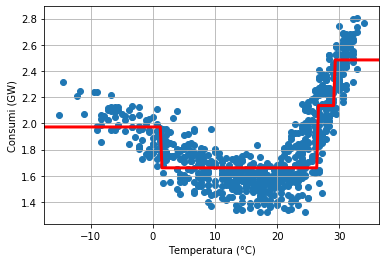

In [100]:
plot_model_on_data(X_train, y_train, model)

- Il modello è in pratica costituito da una funzione con 4 "gradini" orizzontali, corrispondenti alle 4 foglie dell'albero
  - questo è il numero di foglie massimo che potevamo ottenere con `max_depth=2`

In [101]:
model.get_n_leaves()

4

- Data la dimensione limitata dell'albero, il coefficiente R² del modello è inferiore rispetto ai migliori individuati ad es. con regressione polinomiale

In [102]:
model.score(X_train, y_train)

0.7350442543085947

In [103]:
model.score(X_val, y_val)

0.6044663941557535

- Testiamo ora un modello con profondità massima 7

In [104]:
model = DecisionTreeRegressor(max_depth=7, random_state=42)
model.fit(X_train, y_train);

- Il numero di foglie è ora più alto...

In [105]:
model.get_n_leaves()

50

- ...e la funzione del modello è quindi costituita da "gradini" più granulari e precisi

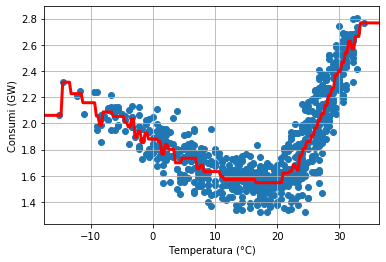

In [106]:
plot_model_on_data(X_train, y_train, model)

- Questo porta a coefficienti R² molto più alti

In [107]:
model.score(X_train, y_train)

0.8362751048568005

In [108]:
model.score(X_val, y_val)

0.7241494393469308

- Come alternativa ad impostare una profondità massima, usiamo `min_samples_split` per non suddividere nodi dell'albero con troppe poche istanze

In [109]:
model = DecisionTreeRegressor(min_samples_split=40, random_state=42)
model.fit(X_train, y_train);

In [110]:
model.get_n_leaves()

31

- Con questa configurazione il modello è più "stabile" in presenza di casi isolati, evitando l'overfitting su di essi

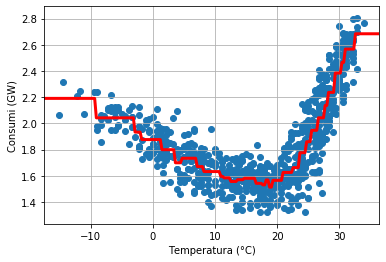

In [111]:
plot_model_on_data(X_train, y_train, model)

- I coefficienti R² sono molto simili a quelli sopra, sia pur con un albero con meno nodi

In [112]:
model.score(X_train, y_train)

0.8335380774593819

In [113]:
model.score(X_val, y_val)

0.719999445526633

- Testiamo ora gli alberi di regressione su un problema di regressione multivariata
- Riprendiamo il problema della predizione dei prezzi delle case in base alle caratteristiche del quartiere

In [114]:
import os.path
if not os.path.exists("housing.csv"):
    from urllib.request import urlretrieve
    urlretrieve("https://git.io/fjGjx", "housing.csv")

In [115]:
housing = pd.read_csv("housing.csv")
housing.head(5)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


- Effettuiamo la solita suddivisione 2/3 training set e 1/3 validation set

In [116]:
X = housing.drop(columns=["MEDV"])
y = housing["MEDV"]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=1/3, random_state=42)

- Anche questa volta iniziamo addestrando un albero con profondità massima 2 per ottenere un esempio semplice

In [117]:
model = DecisionTreeRegressor(max_depth=2, random_state=42)
model.fit(X_train, y_train);

- Otteniamo le rappresentazioni testuale e grafica dell'albero
  - nella rappresentazione grafica, i colori indicano questa volta il valore previsto della variabile dipendente

In [118]:
print(export_text(model, feature_names=list(X.columns)))

|--- LSTAT <= 7.87
|   |--- RM <= 7.44
|   |   |--- value: [29.29]
|   |--- RM >  7.44
|   |   |--- value: [44.40]
|--- LSTAT >  7.87
|   |--- LSTAT <= 16.09
|   |   |--- value: [21.65]
|   |--- LSTAT >  16.09
|   |   |--- value: [13.98]



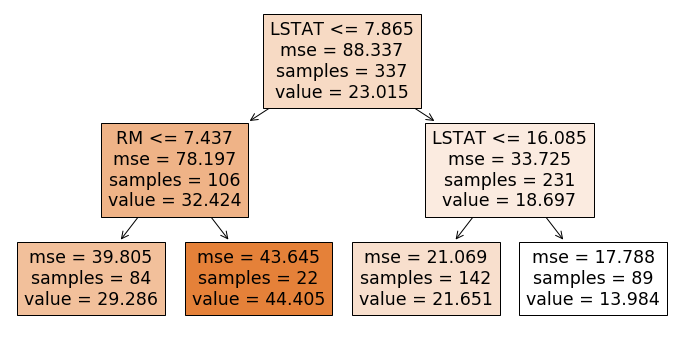

In [119]:
plt.figure(figsize=(12,6))
plot_tree(model, feature_names=list(X.columns), filled=True);

Questo modello si interpreta in questo modo:

- Verifica la percentuale di popolazione con basso reddito (`LSTAT`)
  - se non oltre 7,865%, verifica il numero medio di stanze per abitazione (`RM`)
    - se non oltre 7,437, stima un prezzo di 29.286\$
    - altrimenti, se superiore, stima un prezzo di 44.405\$
  - altrimenti verifica di nuovo `LSTAT`
    - se non oltre 16,085%, stima un prezzo di 21.651\$
    - altrimenti, se superiore, stima un prezzo di 13.984\$
- Nonostante la semplicità del modello, otteniamo un coefficiente R² discreto

In [120]:
model.score(X_train, y_train)

0.7017530046918456

In [121]:
model.score(X_val, y_val)

0.6618358580236576

- Testiamo un modello con un albero più profondo

In [122]:
model = DecisionTreeRegressor(max_depth=5, random_state=42)
model.fit(X_train, y_train);

In [123]:
model.get_n_leaves()

22

In [124]:
print(export_text(model, feature_names=list(X.columns), max_depth=2))

|--- LSTAT <= 7.87
|   |--- RM <= 7.44
|   |   |--- DIS <= 1.56
|   |   |   |--- value: [50.00]
|   |   |--- DIS >  1.56
|   |   |   |--- truncated branch of depth 3
|   |--- RM >  7.44
|   |   |--- RAD <= 16.00
|   |   |   |--- truncated branch of depth 3
|   |   |--- RAD >  16.00
|   |   |   |--- value: [21.90]
|--- LSTAT >  7.87
|   |--- LSTAT <= 16.09
|   |   |--- DIS <= 1.21
|   |   |   |--- value: [50.00]
|   |   |--- DIS >  1.21
|   |   |   |--- truncated branch of depth 3
|   |--- LSTAT >  16.09
|   |   |--- CRIM <= 5.66
|   |   |   |--- truncated branch of depth 3
|   |   |--- CRIM >  5.66
|   |   |   |--- truncated branch of depth 3



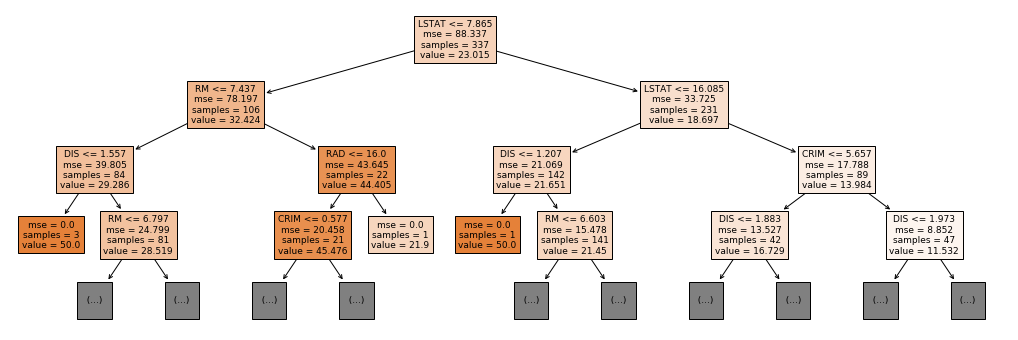

In [125]:
plt.figure(figsize=(18,6))
plot_tree(model, feature_names=list(X.columns), max_depth=3, filled=True);

- Date anche le dimensioni modeste del dataset, arriviamo già al livello 3 ad avere nodi con una sola istanza, che non ha senso dividere ulteriormente
- Con questo modello più complesso, otteniamo un netto miglioramento dei coefficienti R²

In [126]:
model.score(X_train, y_train)

0.9250638118246075

In [127]:
model.score(X_val, y_val)

0.8080334329576639

- Anche in questo caso, senza limitare la profondità otteniamo un modello molto complesso che predice alla perfezione le istanze di training, ma meno preciso sul validation set

In [128]:
model = DecisionTreeRegressor(random_state=42)
model.fit(X_train, y_train);

In [129]:
model.get_depth()

24

In [130]:
model.get_n_leaves()

313

In [131]:
model.score(X_train, y_train)

1.0

In [132]:
model.score(X_val, y_val)

0.7523807137994616

- Testiamo anche un modello ponendo un limite minimo alle istanze in un nodo intermedio
  - possiamo testare `min_samples_split` ad un valore relativo al numero di istanze di training, quì ad es. usiamo 10\%

In [133]:
model = DecisionTreeRegressor(min_samples_split=0.1, random_state=42)
model.fit(X_train, y_train);

- Come visto sopra, otteniamo un albero profondo ma con relativamente poche foglie, alcune delle quali si trovano già ai primi livelli

In [134]:
model.get_depth()

15

In [135]:
model.get_n_leaves()

25

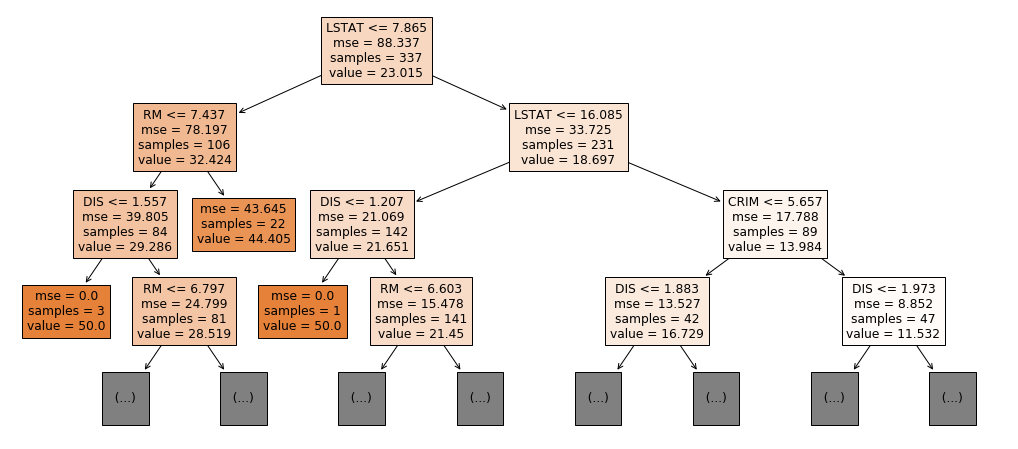

In [136]:
plt.figure(figsize=(18,8))
plot_tree(model, feature_names=list(X.columns), max_depth=3, filled=True);

- Questo albero ha però degli ottimi coefficienti R² comparato a quelli sopra

In [137]:
model.score(X_train, y_train)

0.9032354103362144

In [138]:
model.score(X_val, y_val)

0.8101163489092822

## Esercizio 5: Grid search su alberi di regressione

- Eseguire una grid search sul training set con cross validation a 3 fold su un modello di regressione ad albero con
  - profondità massima pari a 3, 5, 10 o non limitata
  - quantità minima di istanze in ogni nodo intermedio pari a 2 (default) oppure al 2\%, 5\% o 10\% delle istanze totali del dataset
- Estrarre la configurazione migliore e il coefficiente R² ottenuto su training e validation set

In [139]:
from sklearn.model_selection import KFold

In [141]:
model = DecisionTreeRegressor(random_state=42)
grid = {
    "max_depth": [3, 5, 10, None],
    "min_samples_split": [2, 0.02, 0.05, 0.1]
}
kf = KFold(3, shuffle=True, random_state=42)
gs = GridSearchCV(model, grid, cv=kf)
gs.fit(X_train, y_train)
gs.best_params_

{'max_depth': 5, 'min_samples_split': 0.02}

In [142]:
gs.score(X_train, y_train)

0.9250638118246075

In [143]:
gs.score(X_val, y_val)

0.8080334329576639